## <span style="color:lightseagreen"> Exercise 06: Solving the 1D Ising Model with MCMC </span>

In Statistical Mechanics the one-dimensional (1D) Ising Model is exactly resoluble. The Hamiltonian for a system of N spins with nearest neighbors interaction is given by (in the following I will assume units such that $\mu_B=1$ and $k_B=1$):

$$
H = 
-J\sum_{i=1}^N s_i s_{i+1}
-\frac{h}{2}\sum_{i=1}^N (s_i + s_{i+1}) 
$$

where $\{ s_i \}_{i=1,N}$ are spin variables taking values in $\{-1;1\}$, $J>0$ (ferromagnetic model),and with the assumption $s_{N+1} = s_{1}$.

In this exercise we want to compare the analytical and the simulation results for four important quantities in the 1D Ising Model, namely the internal energy, the heat capacity, the magnetization and the magnetic susceptibility.
1. $U(N,T) = \langle H \rangle_{h=0}$
2. $C(N,T) = k_B \beta^2 (\langle H^2 \rangle_{h=0}-\langle H \rangle_{h=0}^2)$ 
3. $\chi(N,T) = \beta \langle (\sum_{i=1,N}s_i)^2 \rangle_{h=0}$
4. $M(N,T,h=0.02)= \langle \sum_{i=1,N}s_i \rangle_{h=0.02}$ 

We intend to estimate these quantities both with the Metropolis algorithm and the Gibbs algorithm at different temperatures.
Prior to the actual simulations, we will make sure that
1. The simulation has reached equilibration, i.e. it has moved away from the initial configuration and explores the possible configurations to the probability associated with its temperature;
2. The blocking used for progressive average has the right size, avoiding correlation bias.
In the end, the quantities of interest will be estimated between $T=0.5$ and $2$. 

In [3]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

Disclaimer in the Metropolis move: a move (or step) in the Metropolis algorithm tries to flip each spin in the chain once. In order to do this we chose to perform a shuffling algorithm on the chain to try to flip each spin in a random order without choosing the same more than once. The shuffling algorithm used is a modern version of the Fisher–Yates shuffle algorithm. There's a but. To generate non-biased samples using this algorithm the pseudo-random number generator should as a necessary condition have more possible seeds than the possible configurations one wants to shuffle ($50!$). This doesn't hold for our prng, but we will use the algorithm nonetheless.

## <span style="color:lightseagreen"> 06.1: Equilibration </span>

In our simulations we always start from a configuration of aligned spins: it is a low energy configuration, corresponding to low temperature. In particular if the external field $h=0$, then it is one of the two ground states of the system (the other one being all spins aligned in the opposite direction). 
So, for our system to reach the desired temperature, some number of steps are necessary. Anyway, those initial configurations are misleading when evaluating properties at the desired temperature. Therefore they should be discarded. 

But how many configurations should be discarded? The answer is empirical, since no sufficient conditions to check are available. Instead, the relaxation of quantities of interest around a certain value is a necessary condition that we will check, with different seeds to avoid prng-dependence and at different temperatures.

For these simulations we used a number of blocks of $50$ and a number of Metropolis/Gibbs steps of $10^5$ per block.

In [20]:

def plotProgAverage(dir,suffix,nsteps, nblocks, T=2.0):

    #import data formatted as table from a .txt file
    udata = np.loadtxt(dir+"output.ene."+suffix)
    cdata = np.loadtxt(dir+"output.heat."+suffix)
    mdata = np.loadtxt(dir+"output.mag."+suffix)
    xdata = np.loadtxt(dir+"output.chi."+suffix)

    #populate and rescale x axis
    x= np.arange(nblocks)*nsteps

    #plot the results with errors
    fig,ax = plt.subplots(2,2,figsize=(14,6))
    axs = ax.flatten()
    axs[0].errorbar(x,udata[:,2],yerr=udata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Energy')
    axs[0].grid(True)
    axs[0].set_ylabel(r"$\frac{U}{N}$ [A.U.]")
    #axs[0].set_xlim(20000,10000)
    axs[0].legend()


    axs[1].errorbar(x,cdata[:,2],yerr=cdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Heat Capacity')
    axs[1].grid(True)
    axs[1].set_ylabel(r"$C$ [A.U.]")
    #axs[1].set_xlim(20000,10000)
    axs[1].legend()

    axs[2].errorbar(x,mdata[:,2],yerr=mdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Magnetization')
    axs[2].grid(True)
    axs[2].set_ylabel(r"$M_{h=0}$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[2].legend()

    axs[3].errorbar(x,xdata[:,2],yerr=xdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Magnetic Susceptibility')
    axs[3].grid(True)
    axs[3].set_ylabel(r"$\chi$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[3].legend()

    fig.supxlabel('#steps')
    #fig.supylabel(r'$\langle r \rangle [a_0]$')

    fig.suptitle(f"Metropolis Simulation at T={T} ",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

    plt.show()


def plotEstimates(suffix,nsteps, nblocks, T=2.0):

    #import data formatted as table from a .txt file
    udata = np.loadtxt("output.ene."+suffix)
    cdata = np.loadtxt("output.heat."+suffix)
    mdata = np.loadtxt("output.mag."+suffix)
    xdata = np.loadtxt("output.chi."+suffix)

    #populate and rescale x axis
    x= np.arange(nblocks)*nsteps

    #plot the results with errors
    fig,ax = plt.subplots(2,2,figsize=(13,5))
    axs = ax.flatten()
    axs[0].errorbar(x,udata[:,1], color="darkolivegreen", ecolor="chartreuse", label='Energy')
    axs[0].grid(True)
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[0].legend()


    axs[1].errorbar(x,cdata[:,1], color="darkolivegreen", ecolor="chartreuse", label='Heat Capacity')
    axs[1].grid(True)
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[1].legend()

    axs[2].errorbar(x,mdata[:,1], color="darkolivegreen", ecolor="chartreuse", label='Magnetization')
    axs[2].grid(True)
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[2].legend()

    axs[3].errorbar(x,xdata[:,1], color="darkolivegreen", ecolor="chartreuse", label='Magnetic Susceptibility')
    axs[3].grid(True)
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[3].legend()

    fig.supxlabel('#steps')
    #fig.supylabel(r'$\langle r \rangle [a_0]$')

    fig.suptitle(f"MC Sim T={T} ",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.8, hspace=0.3)

    plt.show()

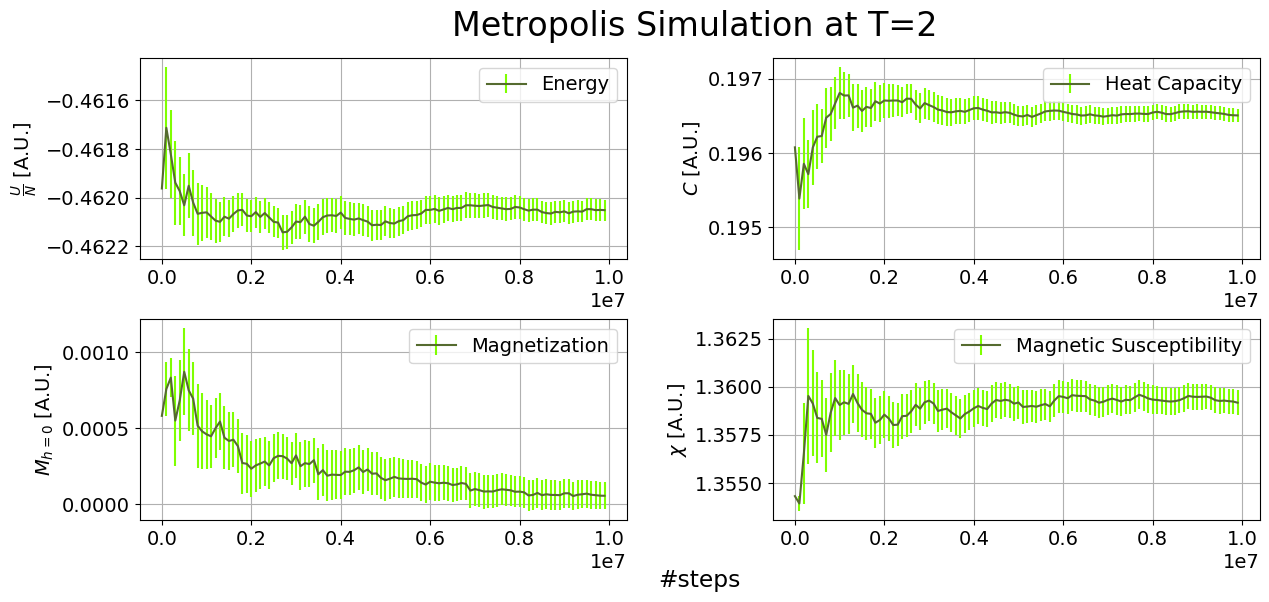

In [21]:
plotProgAverage("equilibration/","metro.T2",100000,100,2)

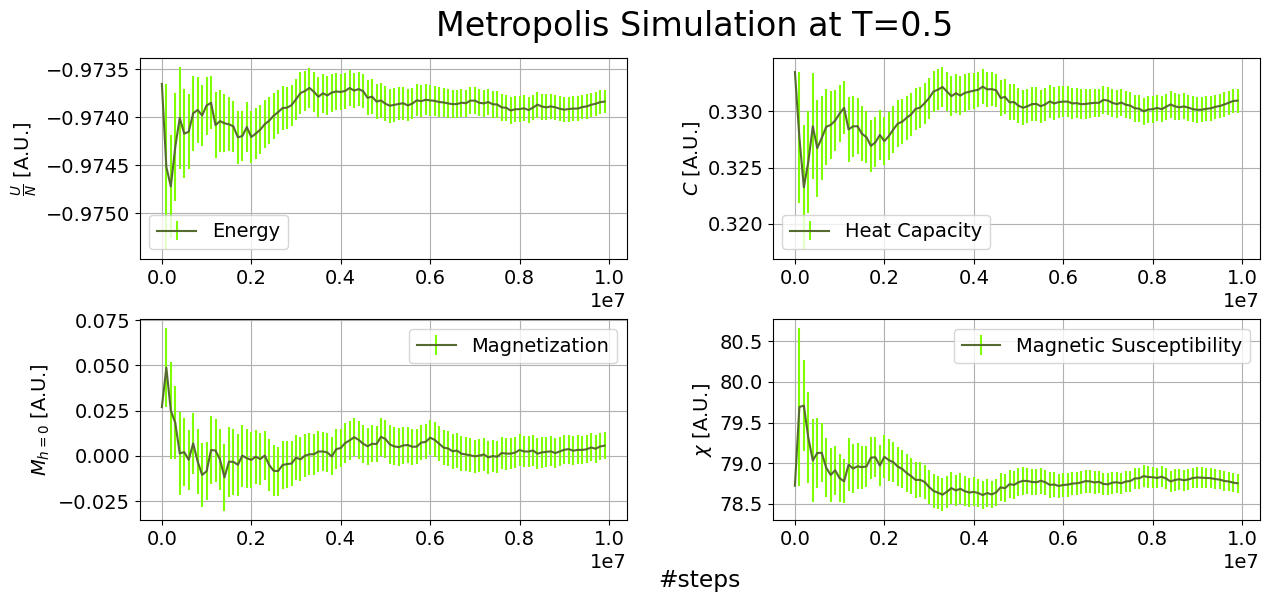

In [22]:
plotProgAverage("equilibration/","metro.T05",100000,100,0.5)

Looking at the plots of the progressive average for different temperatures, we can chose the number of steps to be $4 \times 10^6$, which seems reasonable for the relaxation of quantities of interest at different temperatures.

## <span style="color:lightseagreen"> 06.2: Autocorrelation Function </span>

For these simulations we used a number of blocks of $10^5$ and a number of Metropolis/Gibbs steps of $1$ per block. Infact we are interested in seeing the correlation between different steps in the Metropolis/Gibbs algorithm.

We calculate the correlation function with the FFT algorithm.

In [1]:
def autocorr(x,lags):
    '''fft, don't pad 0s, non partial'''
    mean=x.mean()
    var=np.var(x)
    xp=x-mean

    cf=np.fft.fft(xp)
    sf=cf.conjugate()*cf
    corr=np.fft.ifft(sf).real/var/len(x)

    return corr[:len(lags)]

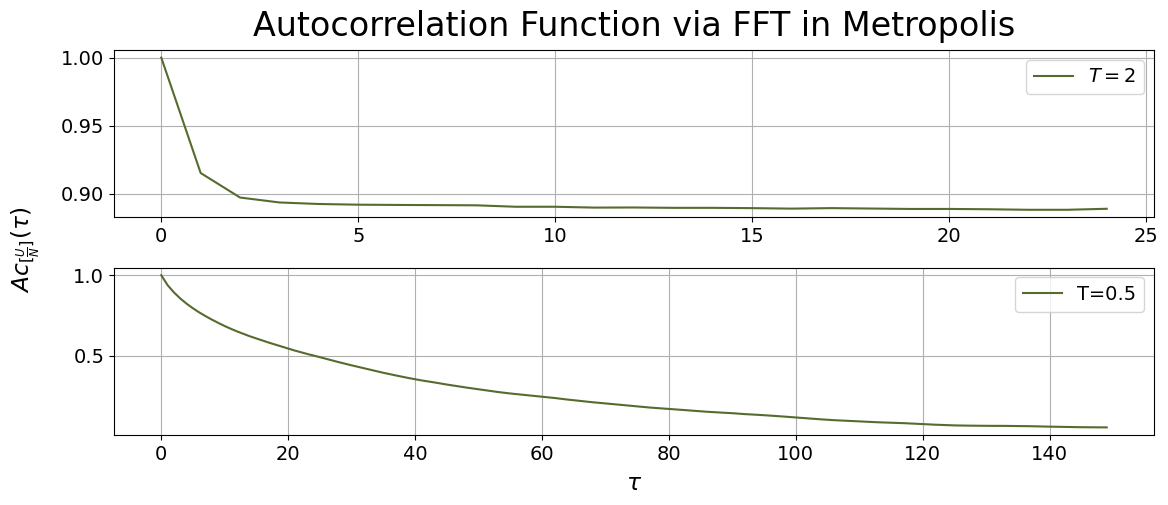

In [19]:

fig,ax = plt.subplots(2,1,figsize=(13,5))
axs = ax.flatten()

udata = np.loadtxt("autocorrelation/output.ene.metro.T2")
acf=autocorr(udata[:,1],range(25))
lags=range(25)
axs[0].plot(lags,acf, color="darkolivegreen", label=r'$T=2$')
axs[0].grid(True)
#axs[0].set_ylim(-0.0065,0.0065)
axs[0].legend()

udata = np.loadtxt("autocorrelation/output.ene.metro.T05")
acf=autocorr(udata[:,1],range(150))
lags=range(150)
axs[1].plot(lags,acf, color="darkolivegreen", label=r'T=0.5')
axs[1].grid(True)
#axs[1].set_ylim(-0.001,0.001)
axs[1].legend()

fig.supxlabel(r'$\tau$')
fig.supylabel(r'$Ac_{[\frac{U}{N}]}(\tau)$')

fig.suptitle("Autocorrelation Function via FFT in Metropolis",fontsize=24)
plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

plt.show()

One can analyze the autocorrelation functions for all the quantities of interest, but we chose the energy per spin as an example. We can crudely say that the autocorrelation length is surely less than $100$ for the different temperatures. This number is important, since the length of a block in the progressive average should be at least twice the autocorrelation length. Since in our simulations we used a far greater number, we are safe from correlations.

It is important to observe that the autocorrelation length rises at lower temperatures. This is of course because at lower temperature the metropolis algorithm visits new configurations in more time, and in a sense it is _less_ ergodic.

## <span style="color:lightseagreen"> 06.3: Results </span>

For our final simulations and in order to produce good results, we used a number of blocks of $30$ and a number of Metropolis/Gibbs steps of $10^6$ per block. This is repeated for $50$ different temperatures in the range $\left[0.5,2.0\right]$. The equilibration number of steps was $4 \times 10^6$. A python script was used to automatize the process.

In [84]:
def plotResult(num_runs=20):

    #import data formatted as table from a .txt file
    udata = np.loadtxt("final_metro_h0/output.ene(T).txt")
    cdata = np.loadtxt("final_metro_h0/output.heat(T).txt")
    mdata = np.loadtxt("final_metro_h002/output.mag(T).txt")
    xdata = np.loadtxt("final_metro_h0/output.chi(T).txt")

    udatag = np.loadtxt("final_gibbs_h0/output.ene(T).txt")
    cdatag = np.loadtxt("final_gibbs_h0/output.heat(T).txt")
    mdatag = np.loadtxt("final_gibbs_h002/output.mag(T).txt")
    xdatag = np.loadtxt("final_gibbs_h0/output.chi(T).txt")

    #populate and rescale x axis
    x = np.linspace(0.5,2.0,num=num_runs)

    points=100
    T = np.linspace(0.2,3.0,num=points)
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    e = -J*( th + ch*thN )/( 1 + thN )
    heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
    X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

    h=0.02 #external field
    b = 1/T

    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns
    M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
            + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

    #plot the results with errors
    fig,ax = plt.subplots(2,2,figsize=(13,9))
    axs = ax.flatten()
    axs[0].errorbar(x,udata[:,2],yerr=udata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis', linestyle= "dashed")
    axs[0].errorbar(x,udatag[:,2],yerr=udatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[0].plot(T, e,color="coral", label="Exact")
    axs[0].grid(True)
    axs[0].set_title("Energy per Spin")
    axs[0].set_ylabel(r"$\frac{U}{N}$ [A.U.]")
    #axs[0].set_xlim(20000,10000)
    axs[0].legend()


    axs[1].errorbar(x,cdata[:,2],yerr=cdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis', linestyle= "dashed")
    axs[1].errorbar(x,cdatag[:,2],yerr=cdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[1].plot(T, heat,color="coral", label="Exact")
    axs[1].grid(True)
    axs[1].set_title("Heat capacity")
    axs[1].set_ylabel(r"$C$ [A.U.]")
    #axs[1].set_xlim(20000,10000)
    axs[1].legend()

    axs[2].errorbar(x,mdata[:,2],yerr=mdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis',linestyle= "dashed")
    axs[2].errorbar(x,mdatag[:,2],yerr=mdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[2].plot(T, M,color="coral", label="Exact")
    axs[2].grid(True)
    axs[2].set_title(r"Magnetization with $h=0.002$")
    axs[2].set_ylabel(r"$M_{h=0.002}$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[2].legend()

    axs[3].errorbar(x,xdata[:,2],yerr=xdata[:,3], color="lime", ecolor="chartreuse", label='Metropolis',linestyle= "dashed")
    axs[3].errorbar(x,xdatag[:,2],yerr=xdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[3].plot(T, X,color="coral", label="Exact")
    axs[3].grid(True)
    axs[3].set_title("Susceptibility")
    axs[3].set_ylabel(r"$\chi$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[3].legend()



    fig.supxlabel('Temperature [Natural Units]')
    #fig.supylabel(r'$\langle r \rangle [a_0]$')

    fig.suptitle("Monte Carlo simulation of 1D Ising model",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.2, hspace=0.3)

    plt.show()


In [98]:
def plotDeltas(num_runs=20):

    #import data formatted as table from a .txt file
    udata = np.loadtxt("final_metro_h0/output.ene(T).txt")
    cdata = np.loadtxt("final_metro_h0/output.heat(T).txt")
    mdata = np.loadtxt("final_metro_h002/output.mag(T).txt")
    xdata = np.loadtxt("final_metro_h0/output.chi(T).txt")

    udatag = np.loadtxt("final_gibbs_h0/output.ene(T).txt")
    cdatag = np.loadtxt("final_gibbs_h0/output.heat(T).txt")
    mdatag = np.loadtxt("final_gibbs_h002/output.mag(T).txt")
    xdatag = np.loadtxt("final_gibbs_h0/output.chi(T).txt")

    #populate and rescale x axis
    x = np.linspace(0.5,2.0,num=num_runs)

    #points=100
    T = x
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN= th**Ns
    ch = 1/th

    e = -J*( th + ch*thN )/( 1 + thN )
    heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
    X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)

    h=0.02 #external field
    b = 1/T

    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns
    M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
            + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)

    zeros = np.zeros(num_runs)

    #plot the results with errors
    fig,ax = plt.subplots(2,2,figsize=(13,9))
    axs = ax.flatten()
    axs[0].errorbar(x,udata[:,2]-e,yerr=udata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis', linestyle= "dashed")
    axs[0].errorbar(x,udatag[:,2]-e,yerr=udatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[0].plot(T, zeros,color="coral", label="Exact")
    axs[0].grid(True)
    axs[0].set_title("Energy per Spin")
    axs[0].set_ylabel(r"$\Delta \frac{U}{N}$ [A.U.]")
    #axs[0].set_xlim(20000,10000)
    axs[0].legend()


    axs[1].errorbar(x,cdata[:,2]-heat,yerr=cdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis', linestyle= "dashed")
    axs[1].errorbar(x,cdatag[:,2]-heat,yerr=cdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[1].plot(T, zeros,color="coral", label="Exact")
    axs[1].grid(True)
    axs[1].set_title("Heat capacity")
    axs[1].set_ylabel(r"$\Delta C$ [A.U.]")
    #axs[1].set_xlim(20000,10000)
    axs[1].legend()

    axs[2].errorbar(x,mdata[:,2]-M,yerr=mdata[:,3], color="darkolivegreen", ecolor="chartreuse", label='Metropolis',linestyle= "dashed")
    axs[2].errorbar(x,mdatag[:,2]-M,yerr=mdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[2].plot(T, zeros,color="coral", label="Exact")
    axs[2].grid(True)
    axs[2].set_title(r"Magnetization with $h=0.002$")
    axs[2].set_ylabel(r"$\Delta M_{h=0.002}$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[2].legend()

    axs[3].errorbar(x,xdata[:,2]-X,yerr=xdata[:,3], color="lime", ecolor="chartreuse", label='Metropolis',linestyle= "dashed")
    axs[3].errorbar(x,xdatag[:,2]-X,yerr=xdatag[:,3], color="darkmagenta", ecolor="fuchsia", label='Gibbs', linestyle= "dotted")
    axs[3].plot(T, zeros,color="coral", label="Exact")
    axs[3].grid(True)
    axs[3].set_title("Susceptibility")
    axs[3].set_ylabel(r"$\Delta \chi$ [A.U.]")
    #axs[0].set_ylim(-0.0065,0.0065)
    axs[3].legend()



    fig.supxlabel('Temperature [Natural Units]')
    #fig.supylabel(r'$\langle r \rangle [a_0]$')

    fig.suptitle("Deviations from Exact Results",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.9, wspace=0.3, hspace=0.3)

    plt.show()

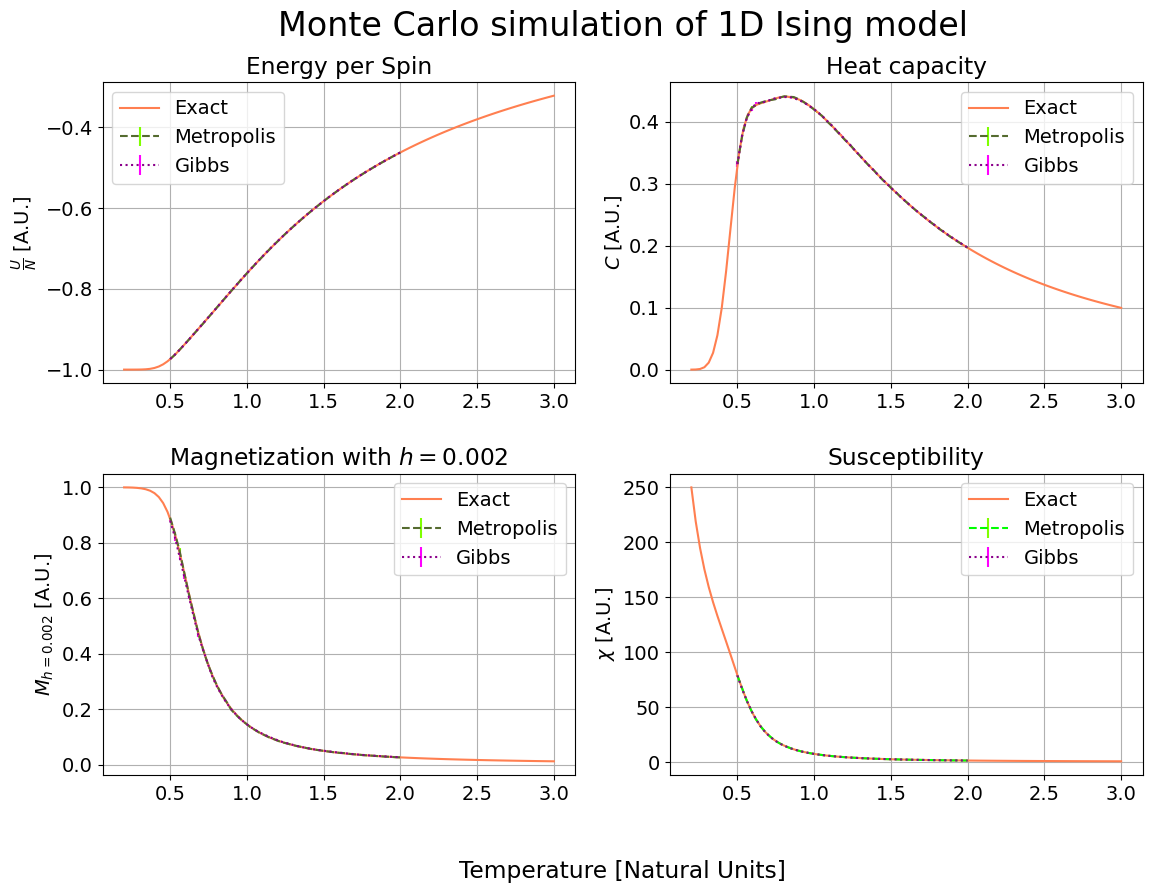

In [99]:
plotResult(num_runs=50)

Uncertainties can't be seen in this scale, so we plot the differences between the simulated and exact values:

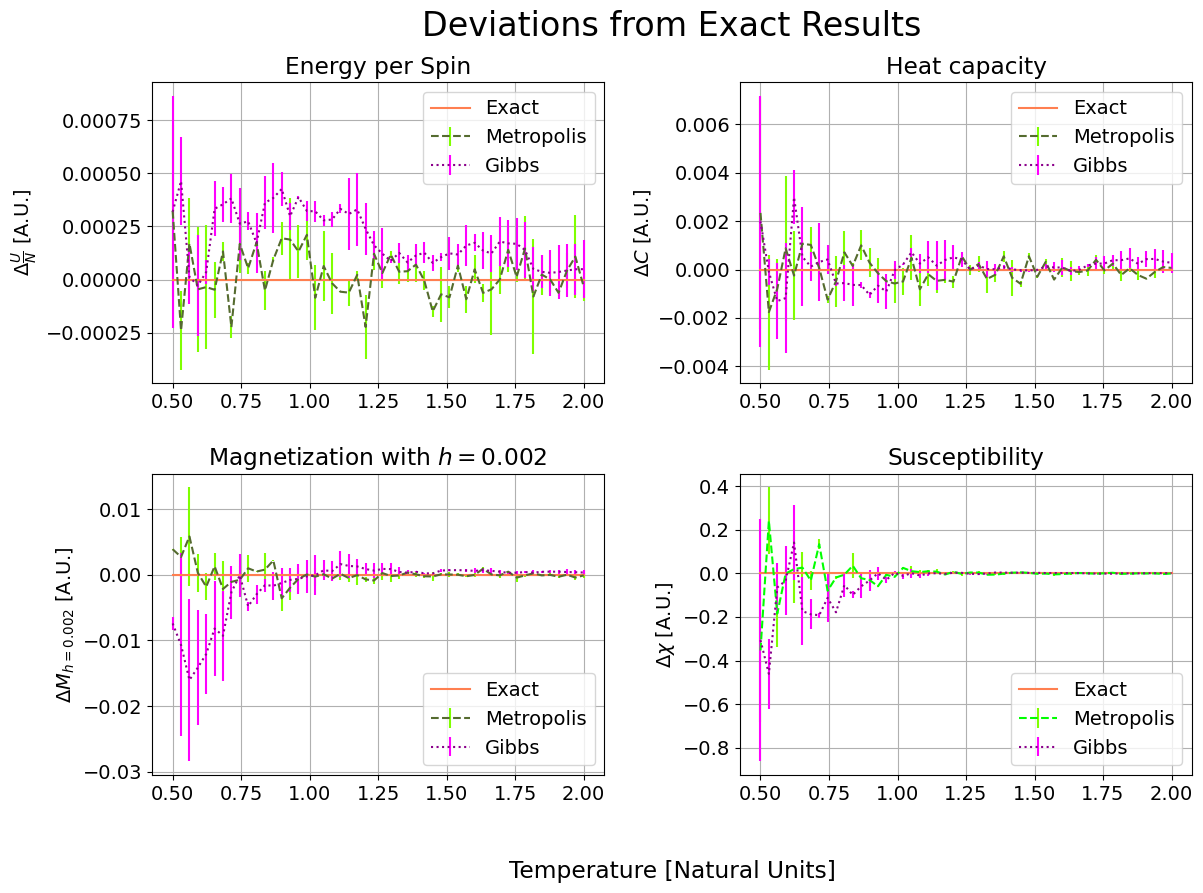

In [100]:
plotDeltas(50)

The simulations reproduce well the theory, at least at one sigma. There's a tendency for the deviations to increase at low temperature. This can be attributed to two reasons: first, at lower temperatures the Metropolis algorithm is less efficient - it has more difficulties in exploring the configuration space. Same can be said for the Gibbs algorithm, since even if each move is accepted, a new move can give back the same configuration. Furthermore, as we implemented it, no blocks of spin can be flipped together, leading to the aforementioned difficulties in exploring the configuration space -, second, the algorithm is _less and less_ ergodic.

In [109]:
def plotAcceptances(num_runs=20):

    #import data formatted as table from a .txt file
    metroacc = np.loadtxt("final_metro_h0/output.acc.0")
    gibbsacc = np.loadtxt("final_gibbs_h0/output.acc.0")

    #populate and rescale x axis
    x = np.linspace(0.5,2.0,num=num_runs)


    #plot the results with errors
    fig,ax = plt.subplots(1,2,figsize=(13,6))
    axs = ax.flatten()
    axs[0].scatter(metroacc[:,0],metroacc[:,1], color="orange", label='Metropolis')
    axs[0].grid(True)
    axs[0].set_title("Metropolis")
    #axs[0].set_ylabel(r"$\Delta \frac{U}{N}$ [A.U.]")
    #axs[0].set_xlim(20000,10000)


    axs[1].scatter(metroacc[:,0],gibbsacc[:,1], color="orange", label='Metropolis')
    axs[1].grid(True)
    axs[1].set_title("Gibbs")
    #axs[1].set_ylabel(r"$\Delta \frac{U}{N}$ [A.U.]")

    fig.supxlabel('Temperature [Natural Units]')
    #fig.supylabel(r'$\langle r \rangle [a_0]$')

    fig.suptitle("Acceptance in the MCMC algorithms",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.85, wspace=0.3, hspace=0.3)

    plt.show()

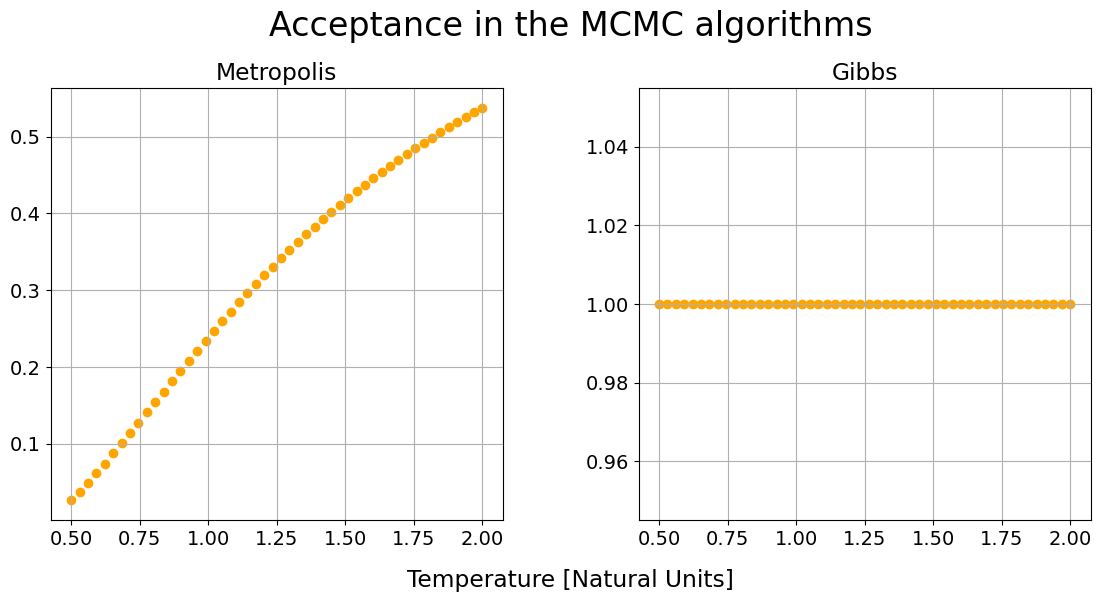

In [110]:
plotAcceptances(50)

In the end we are curious to look at the acceptance of the steps in the algorithm. As we expect it is constant to one for Gibbs, while it varies with temperature in Metropolis. At low temperatures, the acceptance in Metropolis hits a rule-of-thumb-threshold: lower than this it is the algorithm will not perform well.